In [22]:
import os
import multiprocessing
num_cores = multiprocessing.cpu_count()
os.environ['OMP_NUM_THREADS'] = str(num_cores)
os.environ['NUMBA_NUM_THREADS'] = str(num_cores)

from tqdm import tqdm
from functools import partial
import numpy as np
import time
import matplotlib.cm as cm
import matplotlib
import matplotlib.pyplot as plt
import warnings
import gc
import yaml
import argparse
from copy import deepcopy
from scipy.interpolate import interp1d, RegularGridInterpolator

import spaceborne.ell_utils as ell_utils
import spaceborne.cl_preprocessing as cl_utils
import spaceborne.covariance as covmat_utils
import spaceborne.fisher_matrix as fm_utils
import spaceborne.my_module as mm
import spaceborne.cosmo_lib as cosmo_lib
import spaceborne.wf_cl_lib as wf_cl_lib
import spaceborne.pyccl_interface as pyccl_interface
import spaceborne.sigma2_SSC as sigma2_SSC
import spaceborne.onecovariance_interface as oc_interface
import spaceborne.config_checker as config_checker
import spaceborne.responses as responses

script_start_time = time.perf_counter()
# TODO restore this
# ROOT = os.getcwd()
ROOT = os.path.dirname(os.getcwd())

#### General settings
Specify the path of the configuration YAML file (default is `ROOT/example_cfg.yaml`) and shorten variable names

In [23]:
# if you want to run without arguments
with open('example_cfg.yaml', 'r') as f:
    cfg = yaml.safe_load(f)

# define dictionaries corresponding to the relevant sections
general_cfg = cfg['general_cfg']
covariance_cfg = cfg['covariance_cfg']
fm_cfg = cfg['FM_cfg']
pyccl_cfg = covariance_cfg['PyCCL_cfg']
fid_pars_dict = cfg['cosmology']

# TODO delete useless ones!!
# some convenence variables, just to make things more readable
zbins = general_cfg['zbins']
ep_or_ed = general_cfg['EP_or_ED']
ell_max_WL = general_cfg['ell_max_WL']
ell_max_GC = general_cfg['ell_max_GC']
ell_max_3x2pt = general_cfg['ell_max_3x2pt']
center_or_min = general_cfg['center_or_min']
triu_tril = covariance_cfg['triu_tril']
row_col_major = covariance_cfg['row_col_major']
gl_or_lg = covariance_cfg['GL_or_LG']
n_probes = general_cfg['n_probes']
bnt_transform = general_cfg['BNT_transform']
shift_nz_interpolation_kind = covariance_cfg['shift_nz_interpolation_kind']
nz_gaussian_smoothing = covariance_cfg['nz_gaussian_smoothing']  # does not seem to have a large effect...
nz_gaussian_smoothing_sigma = covariance_cfg['nz_gaussian_smoothing_sigma']
shift_nz = covariance_cfg['shift_nz']
normalize_shifted_nz = covariance_cfg['normalize_shifted_nz']
compute_bnt_with_shifted_nz_for_zcuts = covariance_cfg['compute_bnt_with_shifted_nz_for_zcuts']
include_ia_in_bnt_kernel_for_zcuts = covariance_cfg['include_ia_in_bnt_kernel_for_zcuts']
nbl_WL_opt = general_cfg['nbl_WL_opt']
covariance_ordering_2D = covariance_cfg['covariance_ordering_2D']
magcut_lens = general_cfg['magcut_lens']
magcut_source = general_cfg['magcut_source']
use_h_units = general_cfg['use_h_units']
covariance_cfg['probe_ordering'] = (('L', 'L'), (gl_or_lg[0], gl_or_lg[1]), ('G', 'G'))
probe_ordering = covariance_cfg['probe_ordering']
which_pk = general_cfg['which_pk']
which_ng_cov_suffix = 'G' + ''.join(covariance_cfg[covariance_cfg['ng_cov_code'] + '_cfg']['which_ng_cov'])
flat_fid_pars_dict = mm.flatten_dict(fid_pars_dict)
h = flat_fid_pars_dict['h']

# load some nuisance parameters
# note that zbin_centers is not exactly equal to the result of wf_cl_lib.get_z_mean...
# TODO what are these needed for?? It used to be to compute bias at this points...
zbin_centers = cfg['covariance_cfg']['zbin_centers']
ngal_lensing = cfg['covariance_cfg']['ngal_lensing']
ngal_clustering = cfg['covariance_cfg']['ngal_clustering']
galaxy_bias_fit_fiducials = np.array([fid_pars_dict['FM_ordered_params'][f'bG{zi:02d}'] for zi in range(1, 5)])
magnification_bias_fit_fiducials = np.array([fid_pars_dict['FM_ordered_params'][f'bM{zi:02d}'] for zi in range(1, 5)])
dzWL_fiducial = np.array([fid_pars_dict['FM_ordered_params'][f'dzWL{zi:02d}'] for zi in range(1, zbins + 1)])
dzGC_fiducial = np.array([fid_pars_dict['FM_ordered_params'][f'dzWL{zi:02d}'] for zi in range(1, zbins + 1)])

# TODO remove this, pull from the DR1 branch! 
assert np.all(dzWL_fiducial == dzGC_fiducial), 'dzWL and dzGC shifts do not match'
warnings.warn('dzGC_fiducial are equal to dzWL_fiducial')

clr = cm.rainbow(np.linspace(0, 1, zbins))


/tmp/ipykernel_89188/3259435514.py:57: UserWarning: dzGC_fiducial are equal to dzWL_fiducial
  warnings.warn('dzGC_fiducial are equal to dzWL_fiducial')


In [24]:
# define grid to compute the various quantities entering the SSC integrand
z_grid_ssc_integrands = np.linspace(covariance_cfg['Spaceborne_cfg']['z_min_ssc_integrands'],
                                    covariance_cfg['Spaceborne_cfg']['z_max_ssc_integrands'],
                                    covariance_cfg['Spaceborne_cfg']['z_steps_ssc_integrands'])

# some checks on the configurations
config_checker_obj = config_checker.SpaceborneConfigChecker(cfg)
k_txt_label, pk_txt_label = config_checker_obj.run_all_checks()

# instantiate CCL object
ccl_obj = pyccl_interface.PycclClass(fid_pars_dict)

# build array to compress/decompress the Cl/covariance indices and store it into the covariance dictionary
ind = mm.build_full_ind(triu_tril, row_col_major, zbins)
covariance_cfg['ind'] = ind
zpairs_auto, zpairs_cross, zpairs_3x2pt = mm.get_zpairs(zbins)
ind_auto = ind[:zpairs_auto, :].copy()
ind_cross = ind[zpairs_auto:zpairs_cross + zpairs_auto, :].copy()
ind_dict = {('L', 'L'): ind_auto,
            ('G', 'L'): ind_cross,
            ('G', 'G'): ind_auto}
covariance_cfg['ind_dict'] = ind_dict

# TODO remove this!
if not general_cfg['ell_cuts']:
    kmax_h_over_Mpc = general_cfg['kmax_h_over_Mpc_ref']
else:
    general_cfg['ell_cuts_subfolder'] = f'{general_cfg["which_cuts"]}/ell_{general_cfg["center_or_min"]}'


#### Compute number of ell bins, $\ell$ values, $\Delta\ell$ and corresponding edges 
This is done by taking a reference binning (the default case is 32 logarithmically-equispaced bins in the $\ell$ range $[10, 5000]$) and then cutting the number of bins for the different probes depending on the desired $\ell_{\rm max}$.

As an example, a $\ell_{\rm max}^{\rm WL} = 3000$ will fall in the 29th of the 32 above-mentioned bins, so WL will have 29 bins, but with the same centers and edges of the reference case

TODO remove wadd???

In [25]:

# compute ell and delta ell values in the reference (optimistic) case
ell_ref_nbl32, delta_l_ref_nbl32, ell_edges_ref_nbl32 = (
    ell_utils.compute_ells(general_cfg['nbl_WL_opt'], general_cfg['ell_min'], general_cfg['ell_max_WL_opt'],
                           recipe='ISTF', output_ell_bin_edges=True))

# perform the cuts (not the redshift-dependent ones!) on the ell centers and edges
ell_dict = {}
ell_dict['ell_WL'] = np.copy(ell_ref_nbl32[ell_ref_nbl32 < ell_max_WL])
ell_dict['ell_GC'] = np.copy(ell_ref_nbl32[ell_ref_nbl32 < ell_max_GC])
ell_dict['ell_3x2pt'] = np.copy(ell_ref_nbl32[ell_ref_nbl32 < ell_max_3x2pt])
ell_dict['ell_WA'] = np.copy(ell_ref_nbl32[(ell_ref_nbl32 > ell_max_GC) & (ell_ref_nbl32 < ell_max_WL)])
ell_dict['ell_XC'] = np.copy(ell_dict['ell_3x2pt'])

# store edges *except last one for dimensional consistency* in the ell_dict
ell_dict['ell_edges_WL'] = np.copy(ell_edges_ref_nbl32[ell_edges_ref_nbl32 < ell_max_WL])[:-1]
ell_dict['ell_edges_GC'] = np.copy(ell_edges_ref_nbl32[ell_edges_ref_nbl32 < ell_max_GC])[:-1]
ell_dict['ell_edges_3x2pt'] = np.copy(ell_edges_ref_nbl32[ell_edges_ref_nbl32 < ell_max_3x2pt])[:-1]
ell_dict['ell_edges_XC'] = np.copy(ell_dict['ell_edges_3x2pt'])
ell_dict['ell_edges_WA'] = np.copy(
    ell_edges_ref_nbl32[(ell_edges_ref_nbl32 > ell_max_GC) & (ell_edges_ref_nbl32 < ell_max_WL)])[:-1]

for key in ell_dict.keys():
    if ell_dict[key].size > 0:  # Check if the array is non-empty
        assert np.max(ell_dict[key]) > 15, f'ell values for key {key} must *not* be in log space'

# set the corresponding number of ell bins
nbl_WL = len(ell_dict['ell_WL'])
nbl_GC = len(ell_dict['ell_GC'])
nbl_WA = len(ell_dict['ell_WA'])
nbl_3x2pt = nbl_GC

assert len(ell_dict['ell_3x2pt']) == len(ell_dict['ell_XC']) == len(ell_dict['ell_GC']), '3x2pt, XC and GC should '\
    ' have the same number of ell bins'
assert np.all(ell_dict['ell_3x2pt'] == ell_dict['ell_XC']), '3x2pt and XC should have the same ell values'
assert np.all(ell_dict['ell_3x2pt'] == ell_dict['ell_GC']), '3x2pt and GC should have the same ell values'

# TODO the main should not change the cfg
print('$\\ell_min$, $\\ell_max$, number of ell bins for the different probes:')
print(f'WL: {general_cfg["ell_min"]}, {ell_max_WL}, {nbl_WL}')
print(f'GCph: {general_cfg["ell_min"]}, {ell_max_GC}, {nbl_GC}')
print(f'3x2pt: {general_cfg["ell_min"]}, {ell_max_3x2pt}, {nbl_3x2pt}')
general_cfg['nbl_WL'] = nbl_WL
general_cfg['nbl_GC'] = nbl_GC
general_cfg['nbl_3x2pt'] = nbl_3x2pt


# TODO remove this
assert nbl_WL == nbl_3x2pt == nbl_GC, 'use the same number of bins for the moment'

delta_dict = {'delta_l_WL': np.copy(delta_l_ref_nbl32[:nbl_WL]),
              'delta_l_GC': np.copy(delta_l_ref_nbl32[:nbl_GC]),
              'delta_l_WA': np.copy(delta_l_ref_nbl32[nbl_GC:nbl_WL])}


$\ell_min$, $\ell_max$, number of ell bins for the different probes:
WL: 10, 5000, 32
GCph: 10, 5000, 32
3x2pt: 10, 5000, 32


In [26]:
# TODO remove this?
# this is just to make the .format() more compact
variable_specs = {'EP_or_ED': ep_or_ed,
                  'ep_or_ed': ep_or_ed,
                  'zbins': zbins,
                  'ell_max_WL': ell_max_WL, 'ell_max_GC': ell_max_GC, 'ell_max_3x2pt': ell_max_3x2pt,
                  'nbl_WL': nbl_WL, 'nbl_GC': nbl_GC, 'nbl_WA': nbl_WA, 'nbl_3x2pt': nbl_3x2pt,
                  'kmax_h_over_Mpc': kmax_h_over_Mpc, 'center_or_min': center_or_min,
                  'BNT_transform': bnt_transform,
                  'which_ng_cov': which_ng_cov_suffix,
                  'ng_cov_code': covariance_cfg['ng_cov_code'],
                  'magcut_lens': magcut_lens,
                  'magcut_source': magcut_source,
                  'zmin_nz_lens': general_cfg['zmin_nz_lens'],
                  'zmin_nz_source': general_cfg['zmin_nz_source'],
                  'zmax_nz': general_cfg['zmax_nz'],
                  'which_pk': which_pk,
                  'flat_or_nonflat': general_cfg['flat_or_nonflat'],
                  'flagship_version': general_cfg['flagship_version'],
                  }
print('variable_specs:\n')
print(variable_specs)

variable_specs:

{'EP_or_ED': 'EP', 'ep_or_ed': 'EP', 'zbins': 6, 'ell_max_WL': 5000, 'ell_max_GC': 5000, 'ell_max_3x2pt': 5000, 'nbl_WL': 32, 'nbl_GC': 32, 'nbl_WA': 0, 'nbl_3x2pt': 32, 'kmax_h_over_Mpc': 1.0, 'center_or_min': 'center', 'BNT_transform': False, 'which_ng_cov': 'GSSC', 'ng_cov_code': 'Spaceborne', 'magcut_lens': 245, 'magcut_source': 245, 'zmin_nz_lens': 2, 'zmin_nz_source': 2, 'zmax_nz': 25, 'which_pk': 'HMCodeBar', 'flat_or_nonflat': 'Flat', 'flagship_version': 2}


#### Import redshift distribution, $n(z)$
The shape of the input file should be `(zpoints, zbins + 1)`, with `zpoints` the number of points over which the distribution is measured and zbins the number of redshift bins. The first column should contain the redshifts values.

We also define:
- `n_of_z_full`: nz table including a column for the z values
- `n_of_z`:      nz table excluding a column for the z values
- `n_of_z_original`: nz table as imported (it may be subjected to shifts later on)

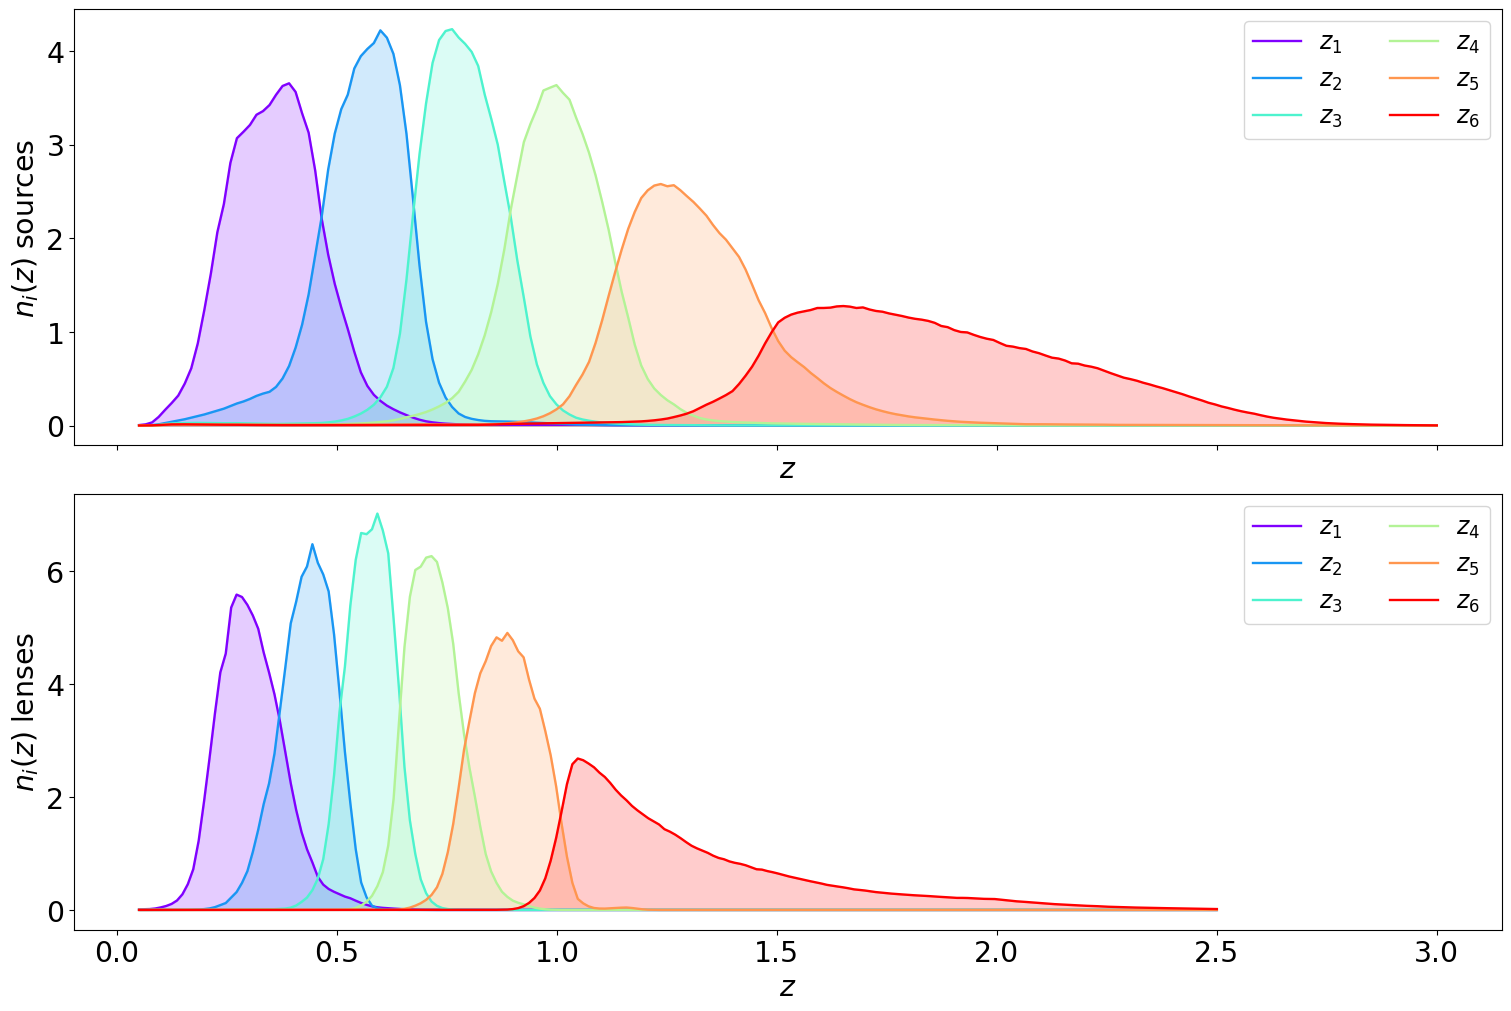

In [27]:

nz_src_full = np.genfromtxt(covariance_cfg["nz_sources_filename"])
nz_lns_full = np.genfromtxt(covariance_cfg["nz_lenses_filename"])

assert nz_src_full.shape[1] == zbins + 1, 'n_of_z must have zbins + 1 columns; the first one must be for the z values'
assert nz_lns_full.shape[1] == zbins + 1, 'n_of_z must have zbins + 1 columns; the first one must be for the z values'
assert np.allclose(nz_lns_full, nz_src_full), 'n_of_z must have zbins + 1 columns; the first one must be for the z values'

zgrid_nz_src = nz_src_full[:, 0]
zgrid_nz_lns = nz_lns_full[:, 0]
nz_src = nz_src_full[:, 1:]
nz_lns = nz_lns_full[:, 1:]

# nz may be subjected to a shift
nz_src_original = nz_src
nz_lns_original = nz_lns

wf_cl_lib.plot_nz_src_lns(zgrid_nz_src, nz_src, zgrid_nz_lns, nz_lns, colors=clr)

#### Compute scale cuts 
In order to do this, we need to:
1. Compute the BNT. This is done with the raw, or unshifted n(z), but only for the purpose of computing the
    $\ell$ cuts - the rest of the code uses a BNT matrix from the shifted $n(z)$ - see also comment below.
2. Compute the kernels for the un-shifted $n(z)$ (for consistency)
3. BNT-transform these kernels (for lensing, it's only the gamma kernel)
4. Compute the effective redshift as first moment of the (BNT-transformed) kernel
5. Compute redshift-dependent $\ell$ cuts

In [28]:
# 1. Compute BNT
from matplotlib.lines import Line2D


assert compute_bnt_with_shifted_nz_for_zcuts is False, 'The BNT used to compute the z_means and ell cuts is just for a simple case: no IA, no dz shift'
assert shift_nz is True, 'The signal (and BNT used to transform it) is computed with a shifted n(z); You could use an un-shifted n(z) for the BNT, but' \
    'this would be slightly inconsistent (but also what I did so far).'
assert include_ia_in_bnt_kernel_for_zcuts is False, 'We compute the BNT just for a simple case: no IA, no shift. This is because we want' \
                                                    ' to compute the z means'

# * IMPORTANT NOTE: The BNT should be computed from the same n(z) (shifted or not) which is then used to compute
# * the kernels which are then used to get the z_means, and finally the ell_cuts, for consistency. In other words,
# * we cannot compute the kernels with a shifted n(z) and transform them with a BNT computed from the unshifted n(z)
# * and viceversa. If the n(z) are shifted, one of the BNT kernels will become negative, but this is just because
# * two of the original kernels get very close after the shift: the transformation is correct.
# * Having said that, I leave the code below in case we want to change this in the future
if nz_gaussian_smoothing:
    n_of_z = wf_cl_lib.gaussian_smmothing_nz(zgrid_nz, nz_src_original, nz_gaussian_smoothing_sigma, plot=True)
if compute_bnt_with_shifted_nz_for_zcuts:
    n_of_z = wf_cl_lib.shift_nz(zgrid_nz, nz_src_original, dzWL_fiducial, normalize=normalize_shifted_nz, plot_nz=False,
                                interpolation_kind=shift_nz_interpolation_kind)

bnt_matrix = covmat_utils.compute_BNT_matrix(
    zbins, zgrid_nz, n_of_z, cosmo_ccl=ccl_obj.cosmo_ccl, plot_nz=False)

# 2. compute the kernels for the un-shifted n(z) (for consistency)
ccl_obj.zbins = zbins
ccl_obj.set_nz(np.hstack((zgrid_nz[:, None], n_of_z)))
ccl_obj.check_nz_tuple(zbins)
ccl_obj.set_ia_bias_tuple(z_grid=z_grid_ssc_integrands)

# set galaxy bias
if general_cfg['which_forecast'] == 'SPV3':
    ccl_obj.set_gal_bias_tuple_spv3(z_grid=z_grid_ssc_integrands,
                                    magcut_lens=magcut_lens,
                                    poly_fit_values=None)

elif general_cfg['which_forecast'] == 'ISTF':
    bias_func_str = general_cfg['bias_function']
    bias_model = general_cfg['bias_model']
    ccl_obj.set_gal_bias_tuple_istf(z_grid=z_grid_ssc_integrands,
                                    bias_function_str=bias_func_str,
                                    bias_model=bias_model)

# set magnification bias
ccl_obj.set_mag_bias_tuple(z_grid=z_grid_ssc_integrands,
                           has_magnification_bias=general_cfg['has_magnification_bias'],
                           magcut_lens=magcut_lens / 10,
                           poly_fit_values=None)

# set Pk
ccl_obj.p_of_k_a = 'delta_matter:delta_matter'

# set kernel arrays and objects
ccl_obj.set_kernel_obj(general_cfg['has_rsd'], covariance_cfg['PyCCL_cfg']['n_samples_wf'])
ccl_obj.set_kernel_arr(z_grid_wf=z_grid_ssc_integrands,
                       has_magnification_bias=general_cfg['has_magnification_bias'])

if general_cfg['which_forecast'] == 'SPV3':
    gal_kernel_plt_title = 'galaxy kernel\n(w/o gal bias!)'
    ccl_obj.wf_galaxy_arr = ccl_obj.wf_galaxy_wo_gal_bias_arr

if general_cfg['which_forecast'] == 'ISTF':
    gal_kernel_plt_title = 'galaxy kernel\n(w/ gal bias)'
    ccl_obj.wf_galaxy_arr = ccl_obj.wf_galaxy_w_gal_bias_arr

# 3. bnt-transform these kernels (for lensing, it's only the gamma kernel, without IA)
wf_gamma_ccl_bnt = (bnt_matrix @ ccl_obj.wf_gamma_arr.T).T

# 4. compute the z means
z_means_ll = wf_cl_lib.get_z_means(z_grid_ssc_integrands, ccl_obj.wf_gamma_arr)
z_means_gg = wf_cl_lib.get_z_means(z_grid_ssc_integrands, ccl_obj.wf_galaxy_arr)
z_means_ll_bnt = wf_cl_lib.get_z_means(z_grid_ssc_integrands, wf_gamma_ccl_bnt)

plt.figure()
for zi in range(zbins):
    plt.plot(z_grid_ssc_integrands, ccl_obj.wf_gamma_arr[:, zi], ls='-', c=clr[zi])
    plt.plot(z_grid_ssc_integrands, wf_gamma_ccl_bnt[:, zi], ls='--', c=clr[zi])
    plt.axvline(z_means_ll_bnt[zi], ls=':', c=clr[zi])

# Create custom legend entries with black color
legend_elements = [
    Line2D([0], [0], color='black', ls='-', label='wf_gamma_ccl'),
    Line2D([0], [0], color='black', ls='--', label='wf_gamma_ccl_BNT'),
    Line2D([0], [0], color='black', ls=':', label='z means BNT')
]

plt.legend(handles=legend_elements)
plt.xlabel('$z$')
plt.ylabel(r'$W_i^{\gamma}(z)$')

# assert np.all(np.diff(z_means_ll) > 0), 'z_means_ll should be monotonically increasing'
# assert np.all(np.diff(z_means_gg) > 0), 'z_means_gg should be monotonically increasing'
# assert np.all(np.diff(z_means_ll_bnt) > 0), ('z_means_ll_bnt should be monotonically increasing '
#                                             '(not a strict condition, valid only if we do not shift the n(z) in this part)')

# 5. compute the ell cuts
ell_cuts_dict = {}
ell_cuts_dict['LL'] = ell_utils.load_ell_cuts(
    kmax_h_over_Mpc, z_means_ll_bnt, z_means_ll_bnt, ccl_obj.cosmo_ccl, zbins, h, general_cfg)
ell_cuts_dict['GG'] = ell_utils.load_ell_cuts(
    kmax_h_over_Mpc, z_means_gg, z_means_gg, ccl_obj.cosmo_ccl, zbins, h, general_cfg)
ell_cuts_dict['GL'] = ell_utils.load_ell_cuts(
    kmax_h_over_Mpc, z_means_gg, z_means_ll_bnt, ccl_obj.cosmo_ccl, zbins, h, general_cfg)
ell_cuts_dict['LG'] = ell_utils.load_ell_cuts(
    kmax_h_over_Mpc, z_means_ll_bnt, z_means_gg, ccl_obj.cosmo_ccl, zbins, h, general_cfg)
ell_dict['ell_cuts_dict'] = ell_cuts_dict  # this is to pass the ll cuts to the covariance module


NameError: name 'zgrid_nz' is not defined

Now compute the BNT used for the rest of the code, i.e., with the same n(z) used in the rest of the code (i.e., shifted or un-shifted)

In [ ]:
if shift_nz:
    n_of_z = wf_cl_lib.shift_nz(zgrid_nz, nz_src_original, dzWL_fiducial, normalize=normalize_shifted_nz, plot_nz=False,
                                interpolation_kind=shift_nz_interpolation_kind)
    nz_tuple = (zgrid_nz, n_of_z)
    bnt_matrix = covmat_utils.compute_BNT_matrix(
        zbins, zgrid_nz, n_of_z, cosmo_ccl=ccl_obj.cosmo_ccl, plot_nz=False)


Re-set n(z) used in CCL class, then re-compute kernels


In [ ]:

ccl_obj.set_nz(np.hstack((zgrid_nz[:, None], n_of_z)))
ccl_obj.set_kernel_obj(general_cfg['has_rsd'], covariance_cfg['PyCCL_cfg']['n_samples_wf'])
ccl_obj.set_kernel_arr(z_grid_wf=z_grid_ssc_integrands,
                       has_magnification_bias=general_cfg['has_magnification_bias'])

if general_cfg['which_forecast'] == 'SPV3':
    gal_kernel_plt_title = 'galaxy\n(excl. gal. bias)'
    ccl_obj.wf_galaxy_arr = ccl_obj.wf_galaxy_wo_gal_bias_arr

if general_cfg['which_forecast'] == 'ISTF':
    gal_kernel_plt_title = 'galaxy\n(incl. gal. bias)'
    ccl_obj.wf_galaxy_arr = ccl_obj.wf_galaxy_w_gal_bias_arr


wf_names_list = ['delta', 'gamma', 'ia', 'magnification', 'lensing', gal_kernel_plt_title]
wf_ccl_list = [ccl_obj.wf_delta_arr, ccl_obj.wf_gamma_arr, ccl_obj.wf_ia_arr, ccl_obj.wf_mu_arr,
               ccl_obj.wf_lensing_arr, ccl_obj.wf_galaxy_arr]

# plot
for wf_idx in range(len(wf_ccl_list)):

    plt.figure()
    for zi in range(zbins):
        plt.plot(z_grid_ssc_integrands, wf_ccl_list[wf_idx][:, zi], ls="-", c=clr[zi], label=r'$z_{%d}$' % (zi + 1))

    plt.tight_layout()
    plt.xlabel('$z$')
    plt.ylabel('$W_i(z)$')
    plt.legend()
    plt.title(f'{wf_names_list[wf_idx]}')
    plt.show()
    plt.close()

#### Compute $C_\ell$

In [ ]:


# compute cls
ccl_obj.cl_ll_3d = ccl_obj.compute_cls(ell_dict['ell_WL'], ccl_obj.p_of_k_a,
                                       ccl_obj.wf_lensing_obj, ccl_obj.wf_lensing_obj, 'spline')
ccl_obj.cl_gl_3d = ccl_obj.compute_cls(ell_dict['ell_XC'], ccl_obj.p_of_k_a,
                                       ccl_obj.wf_galaxy_obj, ccl_obj.wf_lensing_obj, 'spline')
ccl_obj.cl_gg_3d = ccl_obj.compute_cls(ell_dict['ell_GC'], ccl_obj.p_of_k_a,
                                       ccl_obj.wf_galaxy_obj, ccl_obj.wf_galaxy_obj, 'spline')
ccl_obj.cl_wa_3d = ccl_obj.cl_ll_3d[nbl_3x2pt:nbl_WL]

ccl_obj.cl_3x2pt_5d = np.zeros((n_probes, n_probes, nbl_3x2pt, zbins, zbins))
ccl_obj.cl_3x2pt_5d[0, 0, :, :, :] = ccl_obj.cl_ll_3d[:nbl_3x2pt, :, :]
ccl_obj.cl_3x2pt_5d[1, 0, :, :, :] = ccl_obj.cl_gl_3d[:nbl_3x2pt, :, :]
ccl_obj.cl_3x2pt_5d[0, 1, :, :, :] = ccl_obj.cl_gl_3d[:nbl_3x2pt, :, :].transpose(0, 2, 1)
ccl_obj.cl_3x2pt_5d[1, 1, :, :, :] = ccl_obj.cl_gg_3d[:nbl_3x2pt, :, :]

cl_ll_3d, cl_gl_3d, cl_gg_3d, cl_wa_3d = ccl_obj.cl_ll_3d, ccl_obj.cl_gl_3d, ccl_obj.cl_gg_3d, ccl_obj.cl_wa_3d
cl_3x2pt_5d = ccl_obj.cl_3x2pt_5d

fig, ax = plt.subplots(1, 3, figsize=(13, 5))
plt.tight_layout()
for zi in range(zbins):
    zj = zi
    ax[0].loglog(ell_dict['ell_WL'], cl_ll_3d[:, zi, zj], c=clr[zi], label=r'$z_{%d}$' % (zi + 1))
    ax[1].loglog(ell_dict['ell_XC'], cl_gl_3d[:, zi, zj], c=clr[zi])
    ax[2].loglog(ell_dict['ell_GC'], cl_gg_3d[:, zi, zj], c=clr[zi])

ax[0].set_xlabel(r'$\ell$')
ax[1].set_xlabel(r'$\ell$')
ax[2].set_xlabel(r'$\ell$')
ax[0].set_ylabel(r'$C^{ii}_{\ell}$')
ax[0].set_title('LL')
ax[1].set_title('GL')
ax[2].set_title('GG')

# Add overall legend on top
handles, labels = ax[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.16), ncol=3)

plt.tight_layout()
plt.show()

### Super-sample covariance
Compute SSC; this is possible with Spaceborne, OneCovariance or CCL

In [ ]:
# Spaceborne
cov_folder_sb = covariance_cfg['Spaceborne_cfg']['cov_path']
cov_sb_filename = covariance_cfg['Spaceborne_cfg']['cov_filename']
variable_specs['ng_cov_code'] = covariance_cfg['ng_cov_code']
variable_specs['which_ng_cov'] = which_ng_cov_suffix
include_b2 = covariance_cfg['Spaceborne_cfg']['include_b2']

if 'cNG' in covariance_cfg['Spaceborne_cfg']['which_ng_cov']:
    raise NotImplementedError('You should review the which_ng_cov arg in the cov_filename formatting above, "SSC" is'
                              'hardcoded at the moment')

if covariance_cfg['ng_cov_code'] == 'Spaceborne':
    print('Start SSC computation with Spaceborne...')

    if covariance_cfg['Spaceborne_cfg']['which_pk_responses'] == 'halo_model':

        # ! 1. Get halo model responses from CCL
        ccl_obj.initialize_trispectrum(which_ng_cov='SSC', probe_ordering=probe_ordering,
                                       pyccl_cfg=pyccl_cfg, which_pk='_')

        # k and z grids (responses will be interpolated below)
        k_grid_resp = ccl_obj.responses_dict['L', 'L', 'L', 'L']['k_1overMpc']
        a_grid_resp = ccl_obj.responses_dict['L', 'L', 'L', 'L']['a_arr']
        # translate a to z and cut the arrays to the maximum redshift of the SU responses (much smaller range!)
        z_grid_resp = cosmo_lib.a_to_z(a_grid_resp)[::-1]

        dPmm_ddeltab = ccl_obj.responses_dict['L', 'L', 'L', 'L']['dpk12']
        dPgm_ddeltab = ccl_obj.responses_dict['L', 'L', 'G', 'L']['dpk34']
        dPgg_ddeltab = ccl_obj.responses_dict['G', 'G', 'G', 'G']['dpk12']

        # a is flipped w.r.t. z
        dPmm_ddeltab_hm = np.flip(dPmm_ddeltab, axis=1)
        dPgm_ddeltab_hm = np.flip(dPgm_ddeltab, axis=1)
        dPgg_ddeltab_hm = np.flip(dPgg_ddeltab, axis=1)

        # quick sanity check
        assert np.allclose(ccl_obj.responses_dict['L', 'L', 'G', 'L']['dpk34'],
                           ccl_obj.responses_dict['G', 'L', 'G', 'G']['dpk12'], atol=0, rtol=1e-5)
        assert np.allclose(ccl_obj.responses_dict['L', 'L', 'L', 'L']['dpk34'],
                           ccl_obj.responses_dict['L', 'L', 'L', 'L']['dpk12'], atol=0, rtol=1e-5)
        assert dPmm_ddeltab.shape == dPgm_ddeltab.shape == dPgg_ddeltab.shape, 'dPab_ddeltab_hm shape mismatch'

        dPmm_ddeltab_hm_func = RegularGridInterpolator((k_grid_resp, z_grid_resp), dPmm_ddeltab_hm, method='linear')
        dPgm_ddeltab_hm_func = RegularGridInterpolator((k_grid_resp, z_grid_resp), dPgm_ddeltab_hm, method='linear')
        dPgg_ddeltab_hm_func = RegularGridInterpolator((k_grid_resp, z_grid_resp), dPgg_ddeltab_hm, method='linear')
    
    elif covariance_cfg['Spaceborne_cfg']['which_pk_responses'] == 'separate_universe':
                
        k_grid_resp = np.logspace(covariance_cfg['Spaceborne_cfg']['log10_k_min_resp'],
                                   covariance_cfg['Spaceborne_cfg']['log10_k_max_resp'],
                                   covariance_cfg['Spaceborne_cfg']['k_steps_resp'])
        z_grid_resp = z_grid_ssc_integrands
        
        resp_obj = responses.SpaceborneResponses(cfg=cfg, k_grid=k_grid_resp, 
                                                 z_grid=z_grid_resp, 
                                                 cosmo_ccl=ccl_obj.cosmo_ccl, 
                                                 b1_func=ccl_obj.gal_bias_func_ofz)
        r_mm = resp_obj.compute_r1_mm()
        resp_obj.get_rab_and_dpab_ddeltab()
        
        r_gm = resp_obj.r1_gm
        r_gg = resp_obj.r1_gg
        if not covariance_cfg['Spaceborne_cfg']['include_b2']:
            r_gm = resp_obj.r1_gm_nob2
            r_gg = resp_obj.r1_gg_nob2
            
            dPmm_ddeltab = resp_obj.dPmm_ddeltab
            dPgm_ddeltab = resp_obj.dPgm_ddeltab
            dPgg_ddeltab = resp_obj.dPgg_ddeltab
        
    else:
        raise ValueError('which_pk_responses must be either "halo_model" or "separate_universe"')
    
    
    # ! 2. prepare integrands (d2CAB_dVddeltab) and volume element
    k_limber = partial(cosmo_lib.k_limber, cosmo_ccl=ccl_obj.cosmo_ccl, use_h_units=use_h_units)
    r_of_z_func = partial(cosmo_lib.ccl_comoving_distance, use_h_units=use_h_units, cosmo_ccl=ccl_obj.cosmo_ccl)

    # ! divide by r(z)**2 if cl_integral_convention == 'PySSC'
    if covariance_cfg['Spaceborne_cfg']['cl_integral_convention'] == 'PySSC':
        r_of_z_square = r_of_z_func(z_grid_ssc_integrands) ** 2

        wf_delta = ccl_obj.wf_delta_arr / r_of_z_square[:, None]
        wf_gamma = ccl_obj.wf_gamma_arr / r_of_z_square[:, None]
        wf_ia = ccl_obj.wf_ia_arr / r_of_z_square[:, None]
        wf_mu = ccl_obj.wf_mu_arr / r_of_z_square[:, None]
        wf_lensing = ccl_obj.wf_lensing_arr / r_of_z_square[:, None]

    # ! compute the Pk responses(k, z) in k_limber and z_grid_ssc_integrands
    dPmm_ddeltab_interp = RegularGridInterpolator((k_grid_resp, z_grid_resp), dPmm_ddeltab, method='linear')
    dPgm_ddeltab_interp = RegularGridInterpolator((k_grid_resp, z_grid_resp), dPgm_ddeltab, method='linear')
    dPgg_ddeltab_interp = RegularGridInterpolator((k_grid_resp, z_grid_resp), dPgg_ddeltab, method='linear')

    # ! test k_max_limber vs k_max_dPk and adjust z_min_ssc_integrands accordingly
    k_max_resp = np.max(k_grid_resp)
    ell_grid = ell_dict['ell_3x2pt']
    kmax_limber = cosmo_lib.get_kmax_limber(ell_grid, z_grid_ssc_integrands, use_h_units, ccl_obj.cosmo_ccl)

    z_grid_ssc_integrands_test = deepcopy(z_grid_ssc_integrands)
    while kmax_limber > k_max_resp:
        print(f'kmax_limber > k_max_dPk ({kmax_limber:.2f} {k_txt_label} > {k_max_resp:.2f} {k_txt_label}): '
              f'Increasing z_min until kmax_limber < k_max_dPk. Alternetively, increase k_max_dPk or decrease ell_max.')
        z_grid_ssc_integrands_test = z_grid_ssc_integrands_test[1:]
        kmax_limber = cosmo_lib.get_kmax_limber(
            ell_grid, z_grid_ssc_integrands_test, use_h_units, ccl_obj.cosmo_ccl)
        print(f'New z_min = {z_grid_ssc_integrands_test[0]:.3f}')

    dPmm_ddeltab_klimb = np.array(
        [dPmm_ddeltab_interp((k_limber(ell_val, z_grid_ssc_integrands), z_grid_ssc_integrands)) for ell_val in
            ell_dict['ell_WL']])
    dPgm_ddeltab_klimb = np.array(
        [dPgm_ddeltab_interp((k_limber(ell_val, z_grid_ssc_integrands), z_grid_ssc_integrands)) for ell_val in
            ell_dict['ell_XC']])
    dPgg_ddeltab_klimb = np.array(
        [dPgg_ddeltab_interp((k_limber(ell_val, z_grid_ssc_integrands), z_grid_ssc_integrands)) for ell_val in
            ell_dict['ell_GC']])

    # ! volume element
    cl_integral_prefactor = cosmo_lib.cl_integral_prefactor(z_grid_ssc_integrands,
                                                            covariance_cfg['Spaceborne_cfg']['cl_integral_convention'],
                                                            use_h_units=use_h_units,
                                                            cosmo_ccl=ccl_obj.cosmo_ccl)

    # ! observable densities
    d2CLL_dVddeltab = np.einsum('zi,zj,Lz->Lijz', wf_lensing, wf_lensing, dPmm_ddeltab_klimb)
    d2CGL_dVddeltab = \
        np.einsum('zi,zj,Lz->Lijz', wf_delta, wf_lensing, dPgm_ddeltab_klimb) + \
        np.einsum('zi,zj,Lz->Lijz', wf_mu, wf_lensing, dPmm_ddeltab_klimb)
    d2CGG_dVddeltab = \
        np.einsum('zi,zj,Lz->Lijz', wf_delta, wf_delta, dPgg_ddeltab_klimb) + \
        np.einsum('zi,zj,Lz->Lijz', wf_delta, wf_mu, dPgm_ddeltab_klimb) + \
        np.einsum('zi,zj,Lz->Lijz', wf_mu, wf_delta, dPgm_ddeltab_klimb) + \
        np.einsum('zi,zj,Lz->Lijz', wf_mu, wf_mu, dPmm_ddeltab_klimb)

    # ! 3. Compute/load/save sigma2_b
    k_grid_sigma2 = np.logspace(covariance_cfg['Spaceborne_cfg']['log10_k_min_sigma2'],
                                covariance_cfg['Spaceborne_cfg']['log10_k_max_sigma2'],
                                covariance_cfg['Spaceborne_cfg']['k_steps_sigma2'])
    which_sigma2_B = covariance_cfg['Spaceborne_cfg']['which_sigma2_B']

    sigma2_b_path = covariance_cfg['Spaceborne_cfg']['sigma2_b_path']
    sigma2_b_filename = covariance_cfg['Spaceborne_cfg']['sigma2_b_filename']
    if covariance_cfg['Spaceborne_cfg']['load_precomputed_sigma2_b']:
        # TODO define a suitable interpolator if the zgrid doesn't match
        sigma2_b_dict = np.load(f'{sigma2_b_path}/{sigma2_b_filename}', allow_pickle=True).item()
        cfg_sigma2_b = sigma2_b_dict['cfg']  # TODO check that the cfg matches the one
        sigma2_b = sigma2_b_dict['sigma2_b']
    else:
        # TODO input ell and cl mask
        print('Computing sigma2_b...')
        sigma2_b = np.zeros((len(z_grid_ssc_integrands), len(z_grid_ssc_integrands)))
        for z2_idx, z2 in enumerate(tqdm(z_grid_ssc_integrands)):
            sigma2_b[:, z2_idx] = sigma2_SSC.sigma2_func_vectorized(
                z1_arr=z_grid_ssc_integrands,
                z2=z2, k_grid_sigma2=k_grid_sigma2,
                cosmo_ccl=ccl_obj.cosmo_ccl,
                which_sigma2_B=which_sigma2_B,
                ell_mask=None, cl_mask=None)

        if covariance_cfg['Spaceborne_cfg']['save_sigma2_b']:
            sigma2_b_dict_tosave = {
                'cfg': cfg,
                'sigma2_b': sigma2_b,
            }
            np.save(f'{sigma2_b_path}/{sigma2_b_filename}', sigma2_b_dict_tosave, allow_pickle=True)

    mm.matshow(sigma2_b, log=True, abs_val=True, title=r'$\sigma^2_B(z_1, z_2)$')

    plt.figure()
    plt.semilogy(z_grid_ssc_integrands, np.diag(sigma2_b))
    plt.xlabel('$z$')
    plt.ylabel(r'$\sigma^2_B(z_1=z_2)$')
    plt.close()


    z1_idx = len(z_grid_ssc_integrands) // 2
    z1_val = z_grid_ssc_integrands[z1_idx]
    plt.figure()
    plt.plot(z_grid_ssc_integrands, sigma2_b[z1_idx, :])
    plt.xlabel('$z$')
    plt.ylabel(r'$\sigma^2_B(z_2, z1=%.3f)$' % z1_val)
    plt.close()

    # ! 4. Perform the integration calling the Julia module
    print('Performing the 2D integral in Julia...')
    start = time.perf_counter()
    cov_ssc_3x2pt_dict_8D = covmat_utils.ssc_integral_julia(d2CLL_dVddeltab=d2CLL_dVddeltab,
                                               d2CGL_dVddeltab=d2CGL_dVddeltab,
                                               d2CGG_dVddeltab=d2CGG_dVddeltab,
                                               ind_auto=ind_auto, ind_cross=ind_cross,
                                               cl_integral_prefactor=cl_integral_prefactor, sigma2=sigma2_b,
                                               z_grid=z_grid_ssc_integrands,
                                               integration_type=covariance_cfg['Spaceborne_cfg']['integration_type'],
                                               probe_ordering=probe_ordering,
                                               num_threads=general_cfg['num_threads'])
    print('SSC computed with Julia in {:.2f} s'.format(time.perf_counter() - start))

    # If the mask is not passed to sigma2_b, we need to divide by fsky
    if which_sigma2_B == 'full-curved-sky':
        for key in cov_ssc_3x2pt_dict_8D.keys():
            cov_ssc_3x2pt_dict_8D[key] /= covariance_cfg['fsky']
    elif which_sigma2_B == 'mask':
        raise NotImplementedError('Not implemented yet, but very easy to do')
    else:
        raise ValueError(f'which_sigma2_B must be either "full-curved-sky" or "mask"')

    # save the covariance blocks
    # ! note that these files already account for the sky fraction!!
    # TODO fsky suffix in cov name should be added only in this case... or not? the other covariance files don't have this...
    for key in cov_ssc_3x2pt_dict_8D.keys():
        probe_a, probe_b, probe_c, probe_d = key
        if str.join('', (probe_a, probe_b, probe_c, probe_d)) not in ['GLLL', 'GGLL', 'GGGL']:
            np.savez_compressed(
                f'{cov_folder_sb}/{cov_sb_filename.format(probe_a=probe_a,
                                                          probe_b=probe_b, probe_c=probe_c, probe_d=probe_d)}',
                cov_ssc_3x2pt_dict_8D[key])

# this is not very elegant, find a better solution
if covariance_cfg['ng_cov_code'] == 'Spaceborne':
    covariance_cfg['cov_ssc_3x2pt_dict_8D_sb'] = cov_ssc_3x2pt_dict_8D

print('SSC computed with Spaceborne')
# TODO integrate this with Spaceborne_covg

symmetrize_output_dict = {
    ('L', 'L'): False,
    ('G', 'L'): False,
    ('L', 'G'): False,
    ('G', 'G'): False,
}
cov_ssc_sb_3x2pt_dict_10D = mm.cov_3x2pt_dict_8d_to_10d(
    covariance_cfg['cov_ssc_3x2pt_dict_8D_sb'], nbl_3x2pt, zbins, ind_dict, probe_ordering, symmetrize_output_dict)
cov_ssc_sb_3x2pt_10D = mm.cov_10D_dict_to_array(cov_ssc_sb_3x2pt_dict_10D, nbl_3x2pt, zbins, n_probes)
cov_3x2pt_SS_10D = cov_ssc_sb_3x2pt_10D

cov_3x2pt_SS_4D = mm.cov_3x2pt_10D_to_4D(cov_3x2pt_SS_10D, probe_ordering, nbl_3x2pt, zbins, ind.copy(), gl_or_lg)

# to see the individual covariance blocks
cov_3x2pt_SS_2D = mm.cov_4D_to_2DCLOE_3x2pt(cov_3x2pt_SS_4D, block_index='ell', zbins=zbins)

mm.matshow(cov_3x2pt_SS_2D, log=True, abs_val=True, title='SSC 2D')

#### NG covariance with OneCovariance

In [98]:
start_time = time.perf_counter()
if covariance_cfg['ng_cov_code'] == 'OneCovariance' or \
    (covariance_cfg['ng_cov_code'] == 'Spaceborne' and
        not covariance_cfg['OneCovariance_cfg']['use_OneCovariance_SSC']):

    # * 1. save ingredients in ascii format
    oc_path = covariance_cfg['OneCovariance_cfg']['onecovariance_folder'].format(ROOT=ROOT, **variable_specs)
    if not os.path.exists(oc_path):
        os.makedirs(oc_path)

    nofz_ascii_filename = nofz_filename.replace('.dat', f'_dzshifts{shift_nz}.ascii')
    nofz_tosave = np.column_stack((zgrid_nz, n_of_z))
    np.savetxt(f'{oc_path}/{nofz_ascii_filename}', nofz_tosave)

    cl_ll_ascii_filename = f'Cell_ll_SPV3_nbl{nbl_3x2pt}'
    cl_gl_ascii_filename = f'Cell_gl_SPV3_nbl{nbl_3x2pt}'
    cl_gg_ascii_filename = f'Cell_gg_SPV3_nbl{nbl_3x2pt}'
    mm.write_cl_ascii(oc_path, cl_ll_ascii_filename, cl_3x2pt_5d[0, 0, ...], ell_dict['ell_3x2pt'], zbins)
    mm.write_cl_ascii(oc_path, cl_gl_ascii_filename, cl_3x2pt_5d[1, 0, ...], ell_dict['ell_3x2pt'], zbins)
    mm.write_cl_ascii(oc_path, cl_gg_ascii_filename, cl_3x2pt_5d[1, 1, ...], ell_dict['ell_3x2pt'], zbins)

    gal_bias_ascii_filename = f'{oc_path}/gal_bias_table_{general_cfg["which_forecast"]}.ascii'
    ccl_obj.save_gal_bias_table_ascii(z_grid_ssc_integrands, gal_bias_ascii_filename)

    ascii_filenames_dict = {
        'cl_ll_ascii_filename': cl_ll_ascii_filename,
        'cl_gl_ascii_filename': cl_gl_ascii_filename,
        'cl_gg_ascii_filename': cl_gg_ascii_filename,
        'gal_bias_ascii_filename': gal_bias_ascii_filename,
        'nofz_ascii_filename': nofz_ascii_filename,
    }

    # * 2. compute cov using the onecovariance interface class
    print('Start NG cov computation with OneCovariance...')

    # TODO this should be defined globally...
    symmetrize_output_dict = {
        ('L', 'L'): False,
        ('G', 'L'): False,
        ('L', 'G'): False,
        ('G', 'G'): False,
    }

    oc_obj = oc_interface.OneCovarianceInterface(ROOT, cfg, variable_specs)
    oc_obj.build_save_oc_ini(ascii_filenames_dict, print_ini=True)

    oc_obj.call_onecovariance()
    oc_obj.reshape_oc_output(variable_specs, ind_dict, symmetrize_output_dict)

    oc_obj.cov_g_oc_3x2pt_10D = oc_obj.oc_output_to_dict_or_array(
        'G', '10D_array', ind_dict, symmetrize_output_dict)
    oc_obj.cov_ssc_oc_3x2pt_10D = oc_obj.oc_output_to_dict_or_array(
        'SSC', '10D_array', ind_dict, symmetrize_output_dict)
    oc_obj.cov_cng_oc_3x2pt_10D = oc_obj.oc_output_to_dict_or_array(
        'cNG', '10D_array', ind_dict, symmetrize_output_dict)

    print('Time taken to compute OC: {:.2f} m'.format((time.perf_counter() - start_time) / 60))

else:
    oc_obj = None

In [ ]:
# ! standard method for cl_ell_cuts: get the idxs to delete for the flattened 1d cls
if general_cfg['center_or_min'] == 'center':
    prefix = 'ell'
elif general_cfg['center_or_min'] == 'min':
    prefix = 'ell_edges'
else:
    raise ValueError('general_cfg["center_or_min"] should be either "center" or "min"')

ell_dict['idxs_to_delete_dict'] = {
    'LL': ell_utils.get_idxs_to_delete(ell_dict[f'{prefix}_WL'], ell_cuts_dict['LL'], is_auto_spectrum=True, zbins=zbins),
    'GG': ell_utils.get_idxs_to_delete(ell_dict[f'{prefix}_GC'], ell_cuts_dict['GG'], is_auto_spectrum=True, zbins=zbins),
    'WA': ell_utils.get_idxs_to_delete(ell_dict[f'{prefix}_WA'], ell_cuts_dict['LL'], is_auto_spectrum=True, zbins=zbins),
    'GL': ell_utils.get_idxs_to_delete(ell_dict[f'{prefix}_XC'], ell_cuts_dict['GL'], is_auto_spectrum=False, zbins=zbins),
    'LG': ell_utils.get_idxs_to_delete(ell_dict[f'{prefix}_XC'], ell_cuts_dict['LG'], is_auto_spectrum=False, zbins=zbins),
    '3x2pt': ell_utils.get_idxs_to_delete_3x2pt(ell_dict[f'{prefix}_3x2pt'], ell_cuts_dict, zbins, covariance_cfg)
}

# ! 3d cl ell cuts (*after* BNT!!)
if general_cfg['cl_ell_cuts']:
    cl_ll_3d = cl_utils.cl_ell_cut(cl_ll_3d, ell_dict['ell_WL'], ell_cuts_dict['LL'])
    cl_gg_3d = cl_utils.cl_ell_cut(cl_gg_3d, ell_dict['ell_GC'], ell_cuts_dict['GG'])
    cl_3x2pt_5d = cl_utils.cl_ell_cut_3x2pt(cl_3x2pt_5d, ell_cuts_dict, ell_dict['ell_3x2pt'])

# TODO delete this

# store cls and responses in a dictionary
cl_dict_3D = {
    'cl_LL_3D': cl_ll_3d,
    'cl_GG_3D': cl_gg_3d,
    'cl_WA_3D': cl_wa_3d,
    'cl_3x2pt_5D': cl_3x2pt_5d}

rl_dict_3D = {
    'rl_LL_3D': np.ones_like(cl_ll_3d),
    'rl_GG_3D': np.ones_like(cl_gg_3d),
    'rl_WA_3D': np.ones_like(cl_wa_3d),
    'rl_3x2pt_5D': np.ones_like(cl_3x2pt_5d)}

# this is again to test against ccl cls
general_cfg['cl_ll_3d'] = cl_ll_3d
general_cfg['cl_gl_3d'] = cl_gl_3d
general_cfg['cl_gg_3d'] = cl_gg_3d


# ! compute covariance matrix
cov_dict = covmat_utils.compute_cov(general_cfg, covariance_cfg,
                                    ell_dict, delta_dict, cl_dict_3D, rl_dict_3D,
                                    Sijkl=None, BNT_matrix=bnt_matrix, oc_obj=oc_obj)
print('Finished in {:.2f} minutes'.format((time.perf_counter() - script_start_time) / 60))
